In [50]:
import sys
import numpy as np
import csv
import numpy as np
import random
from scipy import stats
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from IPython.display import clear_output
from tqdm import tqdm
from Levenshtein import distance as lev
sys.path.insert(0, '../simulated_alignments/modules')
from classBCR import BCR
from gen_code_DNA import genetic_code
sys.path.insert(0, '../equilibrium_mutability/')
from equilibrium_mutability import site_specific_transitions, site_specific_rates
sys.path.append("../../../Downloads/DCATools")
from sequenceHandler import *
from dca import *
from dca_fn import *
from scipy.cluster.hierarchy import dendrogram, linkage


In [51]:
directory = "postprocessed_alignments/"

In [52]:
input_file = directory+'IGSF_excluded.fasta'
N = len(str(next(SeqIO.parse(open(input_file),'fasta')).seq))
len_seq = N
alph = 21

In [53]:
J, h = importhJ('model_outputs/model_outputs_fullParams.dat',N,alph)

In [54]:
input_file = directory+'IGSF_excluded.fasta'
seq_mat_igsf = fastaToMatrix(input_file)[0]
input_file = directory+'IGHV_trimmed.fasta'
seq_mat_ighv = fastaToMatrix(input_file)[0]
input_file = directory+'IGLV_trimmed.fasta'
seq_mat_iglv = fastaToMatrix(input_file)[0]
input_file = directory+'TRAV_trimmed.fasta'
seq_mat_trav = fastaToMatrix(input_file)[0]

In [55]:
n_igsf = 1000
subset = random.sample(range(seq_mat_igsf.shape[0]),n_igsf)
seq_mat_igsf_subset = seq_mat_igsf[subset,:]

In [56]:
ighv_energies = np.zeros((seq_mat_ighv.shape[0],3))
for i in range(len(ighv_energies)):
    ighv_energies[i,:] = computePottsEnergies(h,J,seq_mat_ighv[i,:])

igsf_energies = np.zeros((seq_mat_igsf_subset.shape[0],3))
for i in range(len(igsf_energies)):
    igsf_energies[i] = computePottsEnergies(h,J,seq_mat_igsf_subset[i,:])

trav_energies = np.zeros((seq_mat_trav.shape[0],3))
for i in range(len(trav_energies)):
    trav_energies[i] = computePottsEnergies(h,J,seq_mat_trav[i,:])



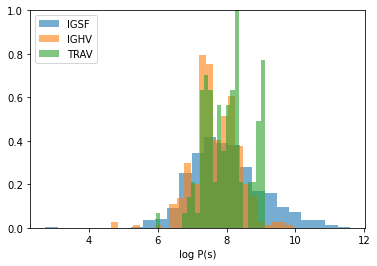

In [57]:
plt.hist(igsf_energies[:,0],alpha = 0.6,density= True,bins = 25,label='IGSF')
plt.hist(ighv_energies[:,0],alpha = 0.6,density= True,bins=25,label = 'IGHV')
plt.hist(trav_energies[:,0],alpha = 0.6,density= True,bins=25,label = 'TRAV')

plt.ylim([0,1])
plt.legend(loc = 'upper left')
plt.xlabel('log P(s)')
plt.savefig('hist.svg')  
plt.show()

In [58]:
#Dictionary of codon frequencies per amino acid:
codon_freqs = {}
# Read table of human codon frequencies (see reference in CSV file):
with open('../relative_mutability/human_codon_frequencies.csv','r') as codon_freq_file:
    for line in codon_freq_file:
        # Skip first 3 lines
        if line.find('#') == -1:
            aa = line.split(' ')[1]
            codon = line.split(' ')[0]
            frequency = line.split(' ')[2]

            if aa not in codon_freqs.keys():
                codon_freqs[aa] = {codon:frequency}
            else:
                codon_freqs[aa][codon] = frequency

    # Normalize so that freqs for each aa sum to 1 (some do not probably because of rounding error in the authors' report)
    for aa in codon_freqs.keys():
        freq_sum = 0
        for codon in codon_freqs[aa].keys():
            freq_sum = freq_sum + float(codon_freqs[aa][codon])

        for codon in codon_freqs[aa].keys():
            codon_freqs[aa][codon] = float(codon_freqs[aa][codon])/freq_sum

In [59]:
nucleotides  =['A','T','C','G']

In [60]:
sub_rate_dict = {'AG':4,'AT':1,'AC':1,'GA':4,'GT':1,'GC':1,'TA':1,'TC':4,'TG':1,'CA':1,'CG':1,'CT':4}

In [61]:
#create spectrum
spectra_mat = np.zeros((21,21))
for i in range(1,21):
    aa = invAaDict[i]
    for codon in codon_freqs[aa]:
        p_codon = codon_freqs[aa][codon]
        for k in range(len(codon)):
            for n in nucleotides:
                if codon[k] != n:
                    p_sub = sub_rate_dict[codon[k] + n]
                    temp = codon[:k] + n + codon[k+1:]
                    j = aaDict[genetic_code[temp]]
                    spectra_mat[i,j] = spectra_mat[i,j] + p_codon*p_sub

In [62]:
#normalize
for i in range(21):
    spectra_mat[i,i] = 0
for i in range(1,21):
    spectra_mat[i,:] = spectra_mat[i,:]/np.sum(spectra_mat[i,:])

In [ ]:
dE_igsf = np.zeros((21,N,n_igsf))
for k in tqdm(range(n_igsf)):
    seq = seq_mat_igsf_subset[k,:]
    for j in range(N):
        for i in range(1,21):
            if seq[j] != 0:
                mutation = invAaDict[seq[j]] + str(j) + invAaDict[i]
                dE_igsf[i,j,k] = computeMutantPottsEnergiesDomains(h,J,seq,[mutation],int(N-1))[0][0]

 72%|███████▏  | 723/1000 [01:31<00:34,  8.03it/s]

In [ ]:
dE_ighv = np.zeros((21,N,seq_mat_ighv.shape[0]))
for k in tqdm(range(seq_mat_ighv.shape[0])):
    seq = seq_mat_ighv[k,:]
    for j in range(N):
        for i in range(1,21):
            if seq[j] != 0:
                mutation = invAaDict[seq[j]] + str(j) + invAaDict[i]
                dE_igsf[i,j,k] = computeMutantPottsEnergiesDomains(h,J,seq,[mutation],int(N-1))[0][0]

In [28]:
def siteWeighteddE(seq_mat,spectra_mat, dE):
    site_weighted_mat = np.zeros(seq_mat.shape)
    for i in range(seq_mat.shape[0]):
        for j in range(seq_mat.shape[1]):
            site_weighted_mat[i,j] = np.sum(spectra_mat[seq_mat[i,j],:]*dE[:,j,i])

(19725, 82)

In [43]:
np.sum(spectra_mat[seq_mat_ighv[1,9],:]*dE_ighv[:,1,9])

0.0

In [45]:
spectra_mat[2,:]

array([0.07142857, 0.        , 0.        , 0.        , 0.        ,
       0.07142857, 0.07142857, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.28571429, 0.14285714, 0.        , 0.        , 0.07142857,
       0.28571429])

In [48]:
dE_igsf[:,5]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.0867464 , -0.07132524, -0.08859732, ...,  0.        ,
        -0.11234772,  0.13162882],
       [-0.35158138, -0.34059523, -0.35155979, ..., -0.19569719,
        -0.35338135, -0.00918299],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.20021121,
         0.        ,  0.25803638],
       [-0.22138045, -0.21213576, -0.22148164, ..., -0.18899459,
        -0.30381871, -0.08427734],
       [-0.34425413, -0.33343471, -0.34452739, ...,  0.00734468,
        -0.33850763,  0.0282567 ]])

In [39]:
np.sum(spectra_mat[1,:])

1.0

In [10]:
igsf_dists = np.zeros((len(seq_mat_igsf_subset[:,0]),len(seq_mat_igsf_subset[:,0])))
for i in tqdm(range(len(seq_mat_igsf_subset[:,0]))):
    for j in range(len(seq_mat_igsf_subset[:,0])):
        igsf_dists[i,j] = hamming_distance(seq_mat_igsf_subset[i,:],seq_mat_igsf_subset[j,:])


100%|██████████| 1000/1000 [03:13<00:00,  5.18it/s]


In [11]:
ighv_dists = np.zeros((len(seq_mat_ighv[:,0]),len(seq_mat_ighv[:,0])))
for i in tqdm(range(len(seq_mat_ighv[:,0]))):
    for j in range(len(seq_mat_ighv[:,0])):
        ighv_dists[i,j] = hamming_distance(seq_mat_ighv[i,:],seq_mat_ighv[j,:])

100%|██████████| 461/461 [00:41<00:00, 11.20it/s]


In [13]:
ighv_igsf_dists = np.zeros((len(seq_mat_ighv[:,0]),len(seq_mat_igsf_subset[:,0])))
for i in tqdm(range(len(seq_mat_ighv[:,0]))):
    for j in range(len(seq_mat_igsf_subset[:,0])):
        ighv_igsf_dists[i,j] = hamming_distance(seq_mat_ighv[i,:],seq_mat_igsf_subset[j,:])

100%|██████████| 461/461 [01:28<00:00,  5.23it/s]


In [ ]:
from scipy.spatial.distance import squareform
condensed_dist_matrix = squareform(ighv_dists)
linkage_data = linkage(condensed_dist_matrix, method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.show() 

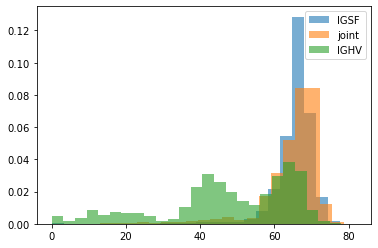

In [17]:
plt.hist(igsf_dists.flatten(),alpha = 0.6,density= True,bins = 25,label='IGSF')
plt.hist(ighv_igsf_dists.flatten(),alpha = 0.6,density= True,bins = 25,label='joint')
plt.hist(ighv_dists.flatten(),alpha = 0.6,density= True,bins = 25,label='IGHV')
plt.legend()
plt.show()